# **Text mining: SENTIMENT ANALYSIS**

## 🎓 Master’s Program in Data Science & Advanced Analytics  
**Nova IMS** | Spring Semester 24/25  
**Course:** Text Mining

## 👥 Team **Group 34**
- **[Diogo Duarte]** | [20240525]
- **[Philippe Dutranoit]** | [20240518]  
- **[Rodrigo Sardinha]** | [20211627]    
- **[Rui Luz]** | [20211628]  

## 📊 Goal of the notebook

This notebook focus on the EDA, giving use a better understanding of what the data looks like and how we could process it in further steps.


---

# **EXPLORATORY DATA ANALYSIS (EDA)**

# 0. Imports

In [211]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import re
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm

In [212]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [213]:
df_train = pd.read_csv('../Data/train.csv')
df_test = pd.read_csv('../Data/test.csv')
df_train

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2
9539,Tupperware Brands among consumer gainers; Unil...,2
9540,vTv Therapeutics leads healthcare gainers; Myo...,2
9541,"WORK, XPO, PYX and AMKR among after hour movers",2


# 1. Overview

In [214]:
df_train.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [215]:
df_train['label'].isna().sum()

np.int64(0)

# 2. Label (Dependent Feature)

For better interpretation, we will add a new column to the dataset that will contain the label as a string, instead of an integer. This will help us understand the sentiment associated with each review.

In [216]:
labels = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'} # the labels are encoded as 0, 1, 2
df_train['sentiment'] = df_train['label'].map(labels)

In [217]:
df_train['sentiment'].describe()

count        9543
unique          3
top       Neutral
freq         6178
Name: sentiment, dtype: object

In [218]:
df_train['sentiment'].value_counts(normalize=True).round(2)

sentiment
Neutral    0.65
Bullish    0.20
Bearish    0.15
Name: proportion, dtype: float64

C:\Users\diogo\AppData\Local\Temp\ipykernel_24976\1855773375.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x='sentiment', order=df_train['sentiment'].value_counts().index, palette=colors)


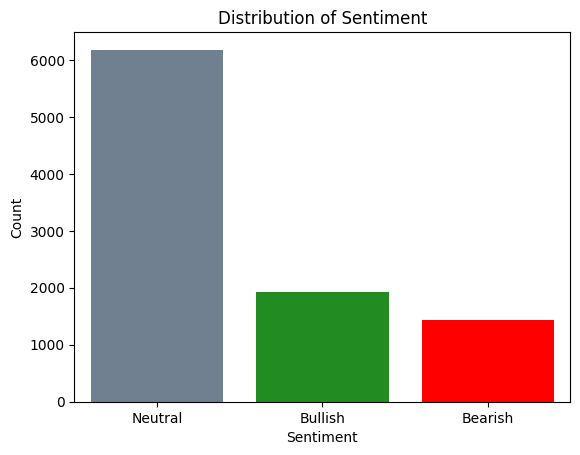

In [219]:
colors = ['slategrey', 'forestgreen', 'red'] # colors for the labels

sns.countplot(data=df_train, x='sentiment', order=df_train['sentiment'].value_counts().index, palette=colors)
plt.title("Distribution of Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Count")

for i, color in enumerate(colors):
    plt.gca().patches[i].set_facecolor(color)

plt.show()

---
## <span style="color: red;">DISCLAIMER</span>
For the purposes of this notebook, we will recode the sentiment labels to enhance the analysis, making them more suitable for our needs. This makes it so that we can classify the sentiments in an ordinal scale, making the feature an ordinal categorical variable, which permits us to perform more interpretation techniques (like boxplots, median, etc.).

In [220]:
# conceptual scale: 0 = Bearish, 1 = Neutral, 2 = Bullish
# this scales the sentiment from negative (Bearish) to positive (Bullish)
df_train['scale'] = df_train['sentiment'].map({
    'Bearish': 0,
    'Neutral': 1,
    'Bullish': 2
})

---

In [221]:
desc = df_train['scale'].describe()
desc = desc.drop(['mean', 'std'])
desc

count    9543.0
min         0.0
25%         1.0
50%         1.0
75%         1.0
max         2.0
Name: scale, dtype: float64

<Axes: >

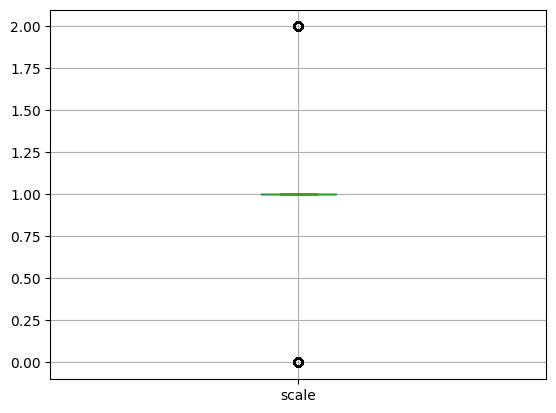

In [222]:
df_train.boxplot(['scale'])

# 3. Text (Independent Feature)

In [223]:
df_train['text'].isna().sum()

np.int64(0)

In [224]:
df_train['text'][0]

'$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT'

### Word Count
Lets start by splitting our texts into tokens and count how many tokens exist in each document.

In [225]:
df_train['word_count']  = df_train['text'].apply(lambda x: len(str(x).split(" ")))
df_train[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


In [226]:
df_train.word_count.describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

In [227]:
df_train[df_train['word_count'] <= 2]

,text,label,sentiment,scale,word_count
1858,SASA聚酯选用英威达PTA技术,2,Neutral,1,1
3090,Brent +4%,1,Bullish,2,2
3943,:),2,Neutral,1,1
3945,@MikeCaymanTrades sometimes,2,Neutral,1,2
3948,@TicToc,2,Neutral,1,1
3980,100% Correct!,2,Neutral,1,2
4360,Damn,2,Neutral,1,1
4440,F5,2,Neutral,1,1
4681,https://t.co/575AH1YRkF,2,Neutral,1,1
4682,https://t.co/9eZPvQhfMq,2,Neutral,1,1


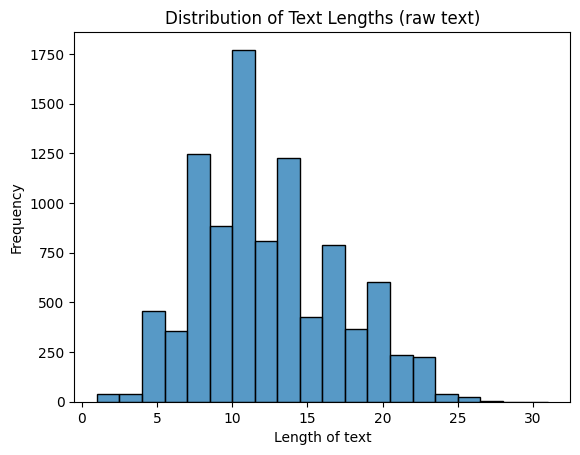

In [228]:
sns.histplot(df_train['word_count'], bins=20)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

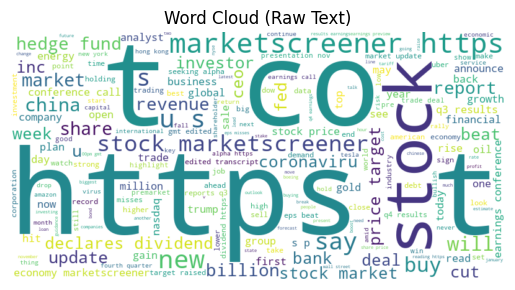

In [229]:
raw_text = ' '.join(df_train['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

In [230]:
df_train['text'][10:20]

10    $HOG - Moody's warns on Harley-Davidson https:...
11    $HXL - Citing aero ties, Wells slashes PT on H...
12    $I - Intelsat cut to Market Perform at Raymond...
13    $KRG: Compass Point cuts to Sell https://t.co/...
14    $LK - Muddy Waters goes short Luckin Coffee ht...
15    $MANT - ManTech downgraded ahead of difficult ...
16                   $MDCO: Oppenheimer cuts to Perform
17    $MPLX $MPC - MPLX cut at Credit Suisse on pote...
18    $MSGN - Imperial downgrades MSG Networks amid ...
19    $MTLS - Piper hits the Materialise sidelines h...
Name: text, dtype: object

In [231]:
# add binary columns "has_link"
df_train['has_link'] = df_train['text'].apply(lambda x: 1 if 'http' in str(x) else 0)

In [232]:
df_train[df_train['has_link']==1]

,text,label,sentiment,scale,word_count,has_link
0,$BYND - JPMorgan reels in expectations on Beyo...,0,Bearish,0,10,1
1,$CCL $RCL - Nomura points to bookings weakness...,0,Bearish,0,14,1
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,Bearish,0,14,1
3,$ESS: BTIG Research cuts to Neutral https://t....,0,Bearish,0,7,1
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,Bearish,0,10,1
...,...,...,...,...,...,...
9513,Luckin Coffee shares halted in premarket; news...,2,Neutral,1,9,1
9529,Stocks making the biggest moves midday: Amazon...,2,Neutral,1,13,1
9534,"Stocks making the biggest moves midday: Tesla,...",2,Neutral,1,15,1
9535,"Stocks making the biggest moves midday: Uber, ...",2,Neutral,1,14,1


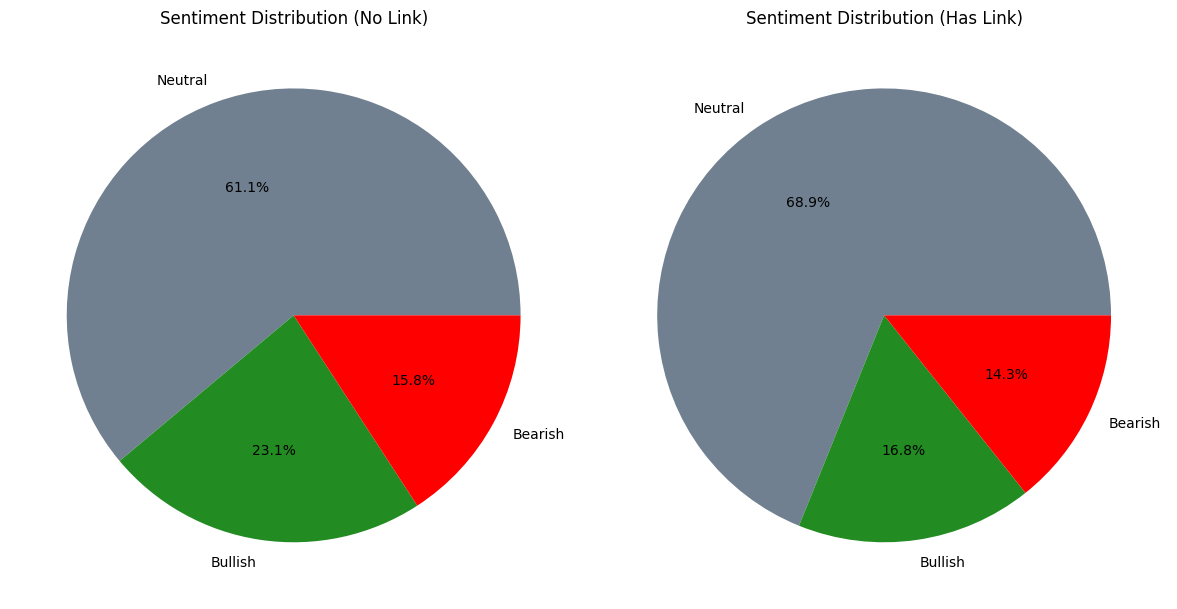

In [233]:
# Pie charts for sentiment distribution by presence of link

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Data for has_link = 0
no_link_counts = df_train[df_train['has_link'] == 0]['sentiment'].value_counts()
axes[0].pie(no_link_counts, labels=no_link_counts.index, autopct='%1.1f%%', colors=['slategrey', 'forestgreen', 'red'])
axes[0].set_title('Sentiment Distribution (No Link)')

# Data for has_link = 1
link_counts = df_train[df_train['has_link'] == 1]['sentiment'].value_counts()
axes[1].pie(link_counts, labels=link_counts.index, autopct='%1.1f%%', colors=['slategrey', 'forestgreen', 'red'])
axes[1].set_title('Sentiment Distribution (Has Link)')

plt.tight_layout()
plt.show()

# 4. Tokenization

In [234]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
lemma = WordNetLemmatizer()

def clean(text_list, lemmatize, stemmer):

    updates = []

    for j in tqdm(text_list):

        text = j

        #LOWERCASE TEXT
        text = text.lower()

        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        # [^&] - Returns a match for any character EXCEPT &.
        # a-zA-Z - Returns a match for any character alphabetically between a and z, lower case or upper case.
        text = re.sub("br", "", text)  # remove "br"
        text = re.sub(r'http\S+', '', text)  # remove URLs
        text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)  # remove punctuation


        #REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stop])

        #Lemmatize
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())

        #Stemming
        if stemmer:
            text = " ".join(stemmer.stem(word) for word in text.split())

        updates.append(text)

    return updates

In [235]:
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

lemmatizer = WordNetLemmatizer() # transform the word to their basic form
STOPWORDS = ENGLISH_STOP_WORDS # remove the common words that do not add much meaning

def clean_text(text: str) -> str:
    """
    Clean the text by:
      1. Lowercasing
      2. Stripping URLs
      3. Stripping @mentions
      4. Stripping # from hashtags
      5. Removing non-alphanumeric (keep spaces)
      6. Collapsing whitespace
      7. Removing stopwords
      8. Lemmatizing (if WordNet is available)
    """
    text = str(text).lower()
    text = re.sub(r'http\S+|www\.\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = text.split()
    cleaned = []
    for tok in tokens:
        if tok not in STOPWORDS:
            try:
                cleaned.append(lemmatizer.lemmatize(tok))
            except:
                cleaned.append(tok)
    return ' '.join(cleaned)

In [236]:
updates = df_train['text'].apply(clean_text)

In [237]:
# updates = clean(df_train['text'], lemmatize = True, stemmer = False)

In [238]:
updates[256]

'huntsman named conviction buy goldman chemical sector shuffle'

In [239]:
df_train['text'][256]

'Huntsman named Conviction Buy at Goldman in chemical sector shuffle'

In [240]:
def update_df(dataframe, list_updated):
    dataframe.update(pd.DataFrame({"text": list_updated}))

In [241]:
update_df(df_train, updates)
df_train.head()

,text,label,sentiment,scale,word_count,has_link
0,bynd jpmorgan reel expectation meat,0,Bearish,0,10,1
1,ccl rcl nomura point booking weakness carnival...,0,Bearish,0,14,1
2,cx cemex cut credit suisse jp morgan weak buil...,0,Bearish,0,14,1
3,es btig research cut neutral,0,Bearish,0,7,1
4,fnko funko slide piper jaffray pt cut,0,Bearish,0,10,1


# 5. Bag of Words (BoW)

In [242]:
bow = CountVectorizer(binary=True)
X = bow.fit_transform(df_train["text"])

In [243]:
print(bow.get_feature_names_out()[10000:10050])  # Display some features

['nvta' 'nvuunto' 'nw' 'nwe' 'nwin' 'nwxpf' 'nxp' 'nxpi' 'nxps' 'ny' 'nyc'
 'nycb' 'nycs' 'nygiants' 'nykredit' 'nymex' 'nymt' 'nyse' 'nyseabg'
 'nyseacb' 'nyseacco' 'nyseafg' 'nyseamexagx' 'nyseanet' 'nyseaqua'
 'nysearoc' 'nyseavya' 'nyseawr' 'nysebco' 'nysebfb' 'nysebkd' 'nysebrc'
 'nysecabo' 'nysecal' 'nysecck' 'nyseclpr' 'nyseclx' 'nysecpb' 'nysectva'
 'nysecub' 'nysecvi' 'nysecvs' 'nysedal' 'nysede' 'nysedrh' 'nyseecl'
 'nyseedu' 'nyseel' 'nyseeog' 'nyseflr']


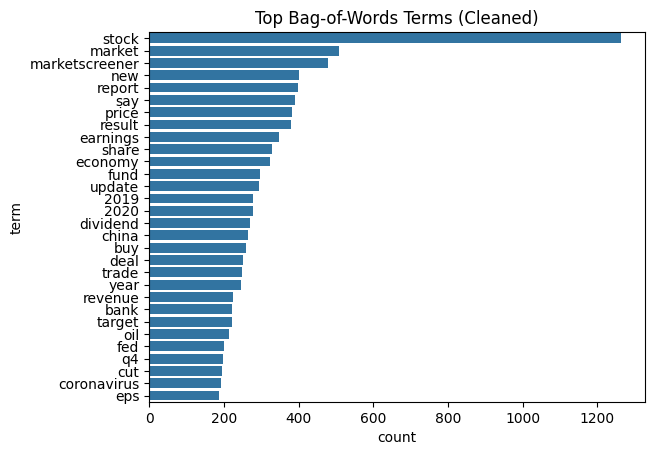

In [244]:
clean_bow_sum = np.array(X.sum(axis=0)).flatten()
clean_terms = bow.get_feature_names_out() # in older versions is get_feature_names()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(30)

sns.barplot(data=clean_top, x='count', y='term')
plt.title("Top Bag-of-Words Terms (Cleaned)")
plt.show()

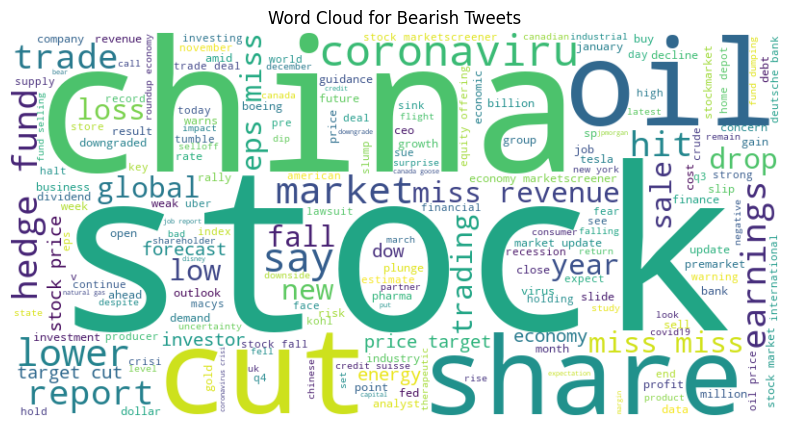

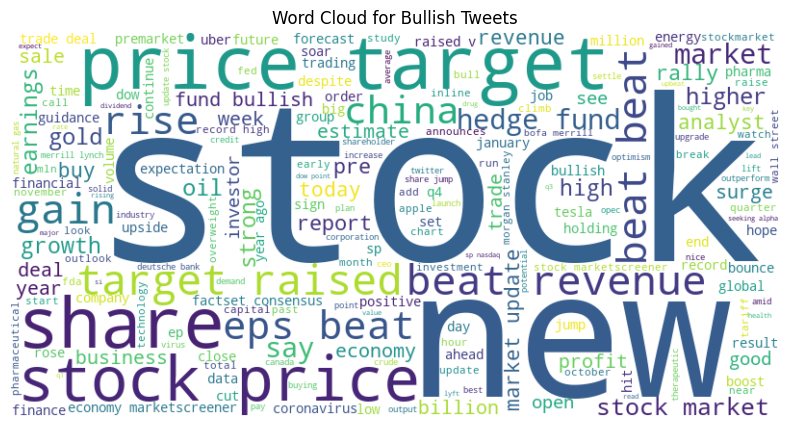

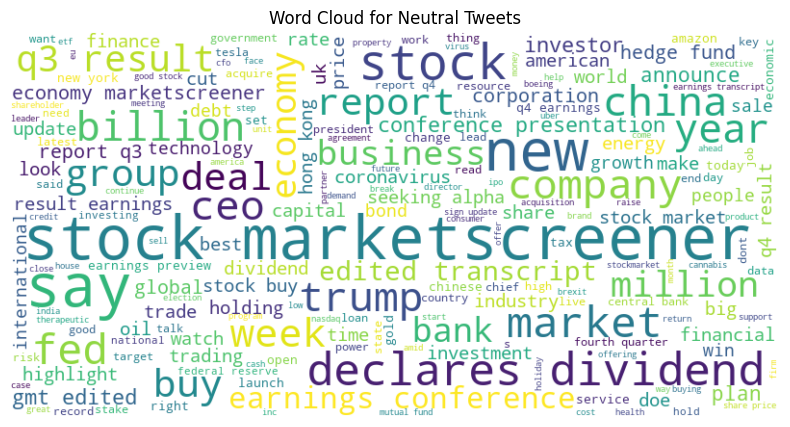

In [245]:
for label, name in zip([0, 1, 2], ['Bearish', 'Bullish', 'Neutral']):
    text = " ".join(df_train[df_train['label'] == label]['text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {name} Tweets')
    plt.show()

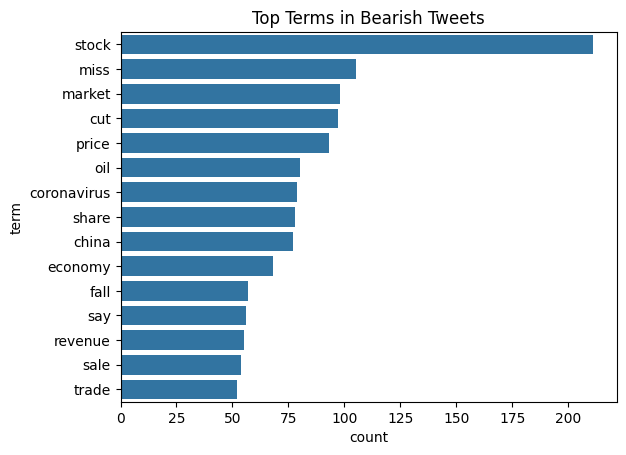

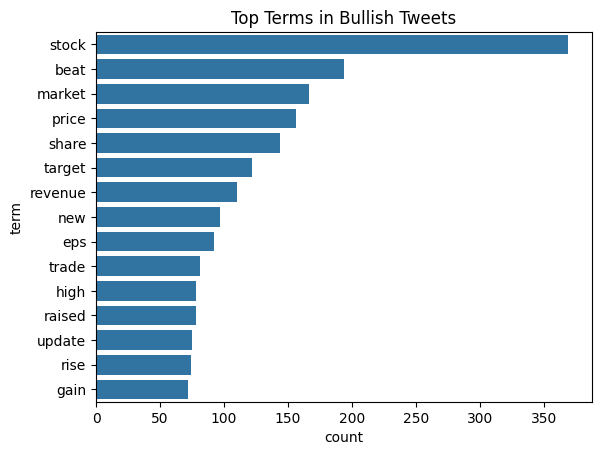

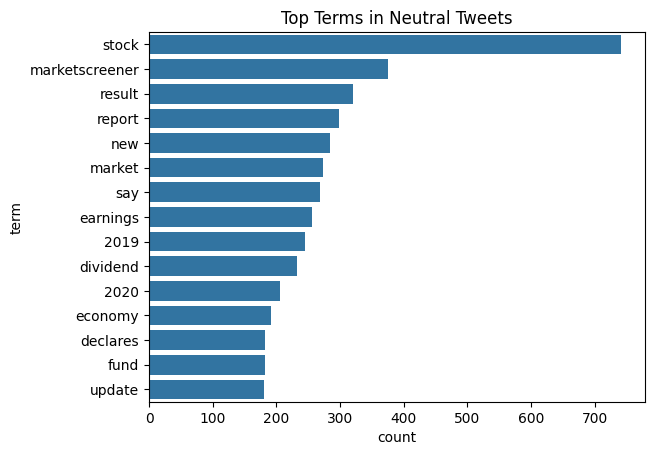

In [246]:
def plot_top_words_by_label(label_value, label_name):
    subset = df_train[df_train['label'] == label_value]
    vectorizer = CountVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(subset['text'])
    words = vectorizer.get_feature_names_out()
    freqs = X.toarray().sum(axis=0)
    top_df = pd.DataFrame({'term': words, 'count': freqs}).sort_values(by='count', ascending=False).head(15)
    
    sns.barplot(data=top_df, x='count', y='term')
    plt.title(f"Top Terms in {label_name} Tweets")
    plt.show()

plot_top_words_by_label(0, "Bearish")
plot_top_words_by_label(1, "Bullish")
plot_top_words_by_label(2, "Neutral")

---
# 6. Train-test Split

In [247]:
X_train, X_val, Y_train, Y_val = train_test_split(
    df_train.drop(columns='label'),
    df_train['label'],
    test_size=0.2,
    random_state=42,
    stratify=df_train['label']
)

In [248]:
Y_train

2186    2
6819    1
6157    0
2462    0
4097    2
       ..
2807    2
704     2
990     1
4362    2
7664    2
Name: label, Length: 7634, dtype: int64

# Export

In [249]:
# X_train.to_csv('../Data/X_train.csv')
# X_val.to_csv('../Data/X_val.csv')
# Y_train.to_csv('../Data/Y_train.csv')
# Y_val.to_csv('../Data/Y_val.csv')